# Salary Predictions Based on Job Descriptions

In [1]:
__author__ = "Thiago do Couto"

# PROBLEM DEFINITION

### The objective is to predict salary based on job descriptions.

## DISCOVER

### Load libraries

In [2]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np
import pandas_profiling as pp

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modeling libraries
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# Allow multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, title):
    width = 10
    height=6
    plt.figure(figsize=(width, height))
    
    ax1=sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2=sns.distplot(BlueFunction, hist=False, color="b", label=BlueName)
    
    plt.title(title)
    plt.xlabel("Proportion of Jobs")
    plt.ylabel("Salary (in thousand dollars)")
    plt.show()
    plt.close()

### Load the data

In [4]:
# Load data into Pandas Dataframe
df_train_feat = pd.read_csv('data/train_features.csv')
df_train_salaries = pd.read_csv('data/train_salaries.csv')
df_test_feat = pd.read_csv('data/test_features.csv')

# Join dataframes
df = df_train_feat.join(df_train_salaries.set_index('jobId'), on = 'jobId')
df.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137


### Clean the data

First we'll check for dataframe consistency.

In [5]:
# Define array for numeric columns loops
intcolumns = ['yearsExperience','milesFromMetropolis','salary']

# Check for column types
print('1 - Check for column types:')
print(df.dtypes)

# Look for duplicates
print('\n2 - Is there any duplicated row? ', df.duplicated().any())

# Look for negative values in numeric data
print('\n3 - How many negative values exists in each numeric column?')
for check in intcolumns:
    print('Column', check, ':', (df[check] < 0).sum())

# Look for zeroes in numeric data
print('\n4 - How many zeroes exists in each numeric column?')
for check in intcolumns:
    print('Column', check, ':', (df[check] == 0).sum())

# Look for NaNs
print('\n5 - Check for NaNs in each attribute:')
print(df.isna().any())

# Look for null values
print('\n6 - Check null values in each attribute:')
print(df.isnull().any())

1 - Check for column types:
jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

2 - Is there any duplicated row?  False

3 - How many negative values exists in each numeric column?
Column yearsExperience : 0
Column milesFromMetropolis : 0
Column salary : 0

4 - How many zeroes exists in each numeric column?
Column yearsExperience : 39839
Column milesFromMetropolis : 10123
Column salary : 5

5 - Check for NaNs in each attribute:
jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

6 - Check null values in each attribute:
jobId               

Now we'll execute data cleaning.

In [6]:
df.profile_report()

In [7]:
# As there were only 5 entries (< 0,05%) with 'salary' == 0, those observations will be removed from the dataset
df.drop(df[df['salary'] == 0].index, inplace = True)

#### The 'milesFromMetropolis' and 'yearsExperience' attributes may have ZEROES
#### E.g.: The person lives at the metropolis and is a novice.

In [8]:
# We'll drop unecessary columns as they are or unique or doesn't help us to build the model
df.drop('jobId', axis=1, inplace=True)
df.drop('companyId', axis=1, inplace=True)

### Explore the data (EDA)

In [9]:
# Check for numeric summary of the dataframe
df.describe()

# Check for value distribution in discrete attibutes
strcolumns = ['jobType', 'degree', 'major', 'industry']
for check in strcolumns:
    df[check].value_counts().to_frame()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


,jobType
SENIOR,125886
VICE_PRESIDENT,125234
MANAGER,125120
CTO,125045
JANITOR,124971
CEO,124778
JUNIOR,124592
CFO,124369


,degree
HIGH_SCHOOL,236975
NONE,236853
BACHELORS,175495
DOCTORAL,175362
MASTERS,175310


,major
NONE,532353
CHEMISTRY,58875
LITERATURE,58684
ENGINEERING,58594
BUSINESS,58518
PHYSICS,58410
COMPSCI,58382
BIOLOGY,58379
MATH,57800


,industry
WEB,143205
AUTO,142941
FINANCE,142866
EDUCATION,142819
OIL,142770
HEALTH,142755
SERVICE,142639


#### Then we'll check the distribution of the 'salary' attribute.

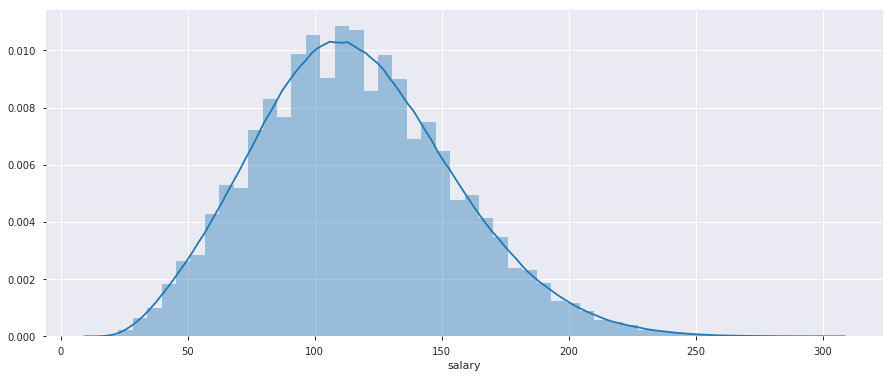

In [10]:
# Plot histogram and distribution of the target variable
plt.figure(figsize = (15,6))
sns.distplot(df['salary'])
plt.show();

#### The 'salary' attribute seems to be normally distributed.

#### We'll then look for correlations between the other attributes and the 'salary' target.

In [11]:
# Define a function to order Boxplots through 'salary' median
def sorted_boxplot(df, xval, yval):
    plt.figure(figsize = (15,6))
    tempdf = pd.DataFrame({col: vals[yval] for col, vals in df.groupby(xval)})
    meds = tempdf.median().sort_values()
    sns.boxplot(data = df, x = df[xval], y = yval, order = tempdf[meds.index])  
    plt.show()

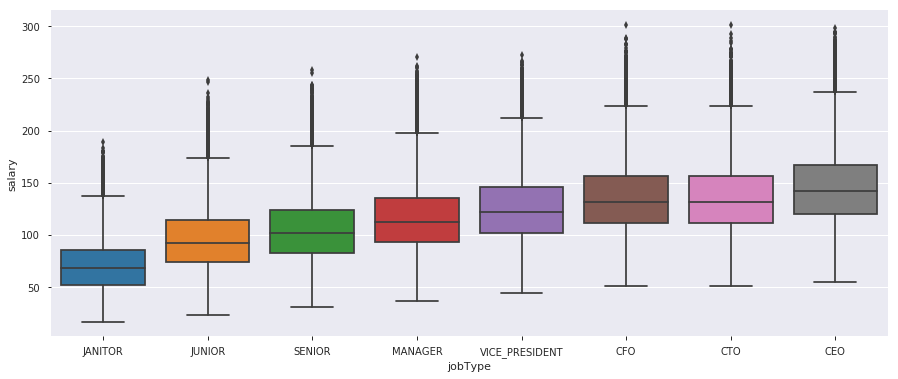

In [12]:
# Plot the 'jobType' vs 'salary' comparison
sorted_boxplot(df, xval = 'jobType', yval = 'salary')

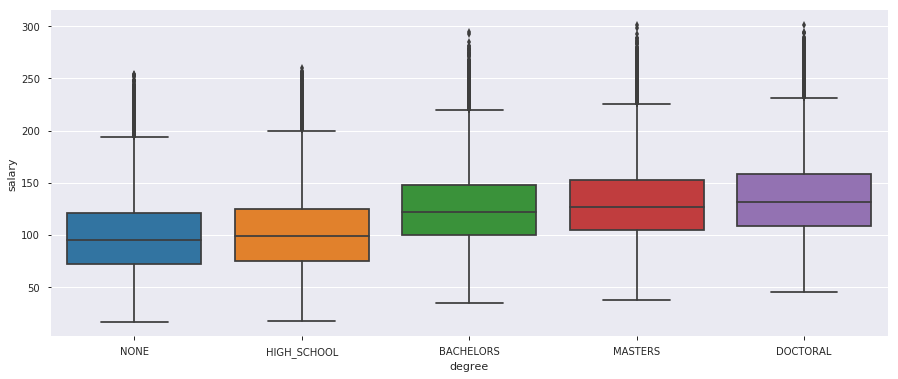

In [13]:
# Plot the 'degree' vs 'salary' comparison
sorted_boxplot(df, xval = 'degree', yval = 'salary')

**As we can see, that's a clear relation between high salaries and high degree. That makes sense.**

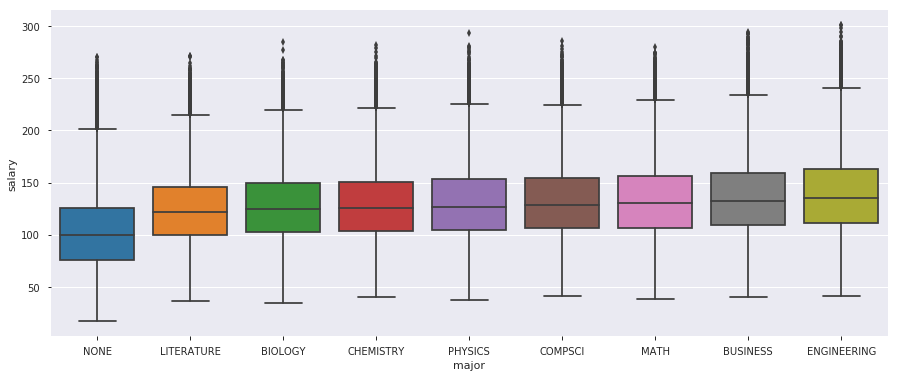

In [14]:
# Plot the 'major' vs 'salary' comparison
sorted_boxplot(df, xval = 'major', yval = 'salary')

**We can see that professionals without any major clearly have lower salary, in average. Therefore, it's not possible to see any strong correlation between a specific major and highest salaries.**

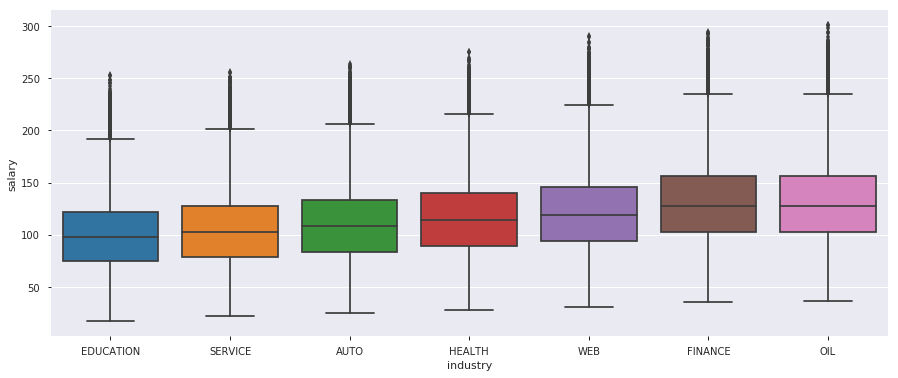

In [15]:
# Plot the 'industry' vs 'salary' comparison
sorted_boxplot(df, xval = 'industry', yval = 'salary')

**As we can see, Finance and Oil & Gas pays somewhat higher salaries than the other industries.**

In [16]:
# Check for correlation between the numerical variables
df.corr()

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


In [20]:
# Reduce the Dataset size to decrease training time
df = df.sample(frac=0.001)
df.shape

In [22]:
# We'll hot encode the categorical variables so we can build the model
df_train = pd.get_dummies(df)
df_train.head()
df.size

,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
466197,16,13,157,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
566613,8,49,124,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
67919,1,50,51,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
388565,13,25,102,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
813750,13,80,137,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


7000

#### As 'milesFromMetropolis' increases, 'salary' decreases. Therefore it's a negative correlation (-0.29).
#### As 'yearsExperience' increases, 'salary' also increases. It's a positive correlation (0.37).

### Establish a baseline

#### Split the data into Train and Test sets.

In [23]:
X = df_train[df_train.loc[ : , df_train.columns != 'salary'].columns]
y = df_train['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Initialize and train the Linear Regression Model as we'll use it as baseline.

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train);

#### Let's view the coeficients:

In [25]:
# Slope
print(lr_model.coef_)
# Intercept
print(lr_model.intercept_)

[ 1.89391506e+00 -3.49648265e-01 -1.04150559e+12 -1.04150559e+12
 -1.04150559e+12 -1.04150559e+12 -1.04150559e+12 -1.04150559e+12
 -1.04150559e+12 -1.04150559e+12  3.05128602e+11  3.05128602e+11
  3.05128602e+11  3.05128602e+11  3.05128602e+11  6.58535101e+11
  6.58535101e+11  6.58535101e+11  6.58535101e+11  6.58535101e+11
  6.58535101e+11  6.58535101e+11  6.58535101e+11  6.58535101e+11
 -1.18810426e+12 -1.18810426e+12 -1.18810426e+12 -1.18810426e+12
 -1.18810426e+12 -1.18810426e+12 -1.18810426e+12]
1265946151863.574


#### Now let's make the predictions. We'll store them in the 'yhat' object.

In [26]:
yhat = lr_model.predict(X_train)
print('The first 5 predictions are: ', yhat[0:5])

The first 5 predictions are:  [ 68.64624023 103.42895508 118.55419922 102.19335938 152.88085938]


#### The mean squared error (MSE) can now be evaluated. MSE will be used along with accuracy and R-squared to evaluate the baseline model and determine if subsequent models have improved over the established baseline.

In [27]:
mse = mean_squared_error(y_train, yhat)
mse

380.19723577916625

In [28]:
# Print accuracy score using 5-fold cross validation
scores = cross_val_score(lr_model, X_train, y_train, cv=5)
print("5-Fold Cross Validation Accuracy (train data):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (train data): 0.7088765416932074 0.04104007425454257


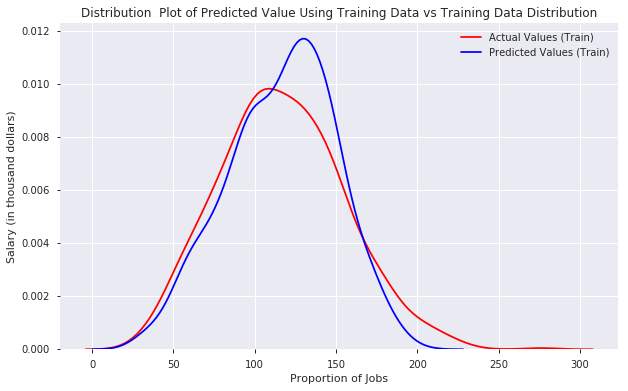

In [29]:
# View distribution of actual salaries compared to predicted salaries
Title = 'Distribution  Plot of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [30]:
# Store linear regression predictions in variable
yhat_test = lr_model.predict(X_test)

In [31]:
# Print MSE of training data
print("The mean squared error of our test set predicitons is:", mean_squared_error(y_test, yhat_test))

The mean squared error of our test set predicitons is: 442.5887087649107


#### The MSE for the training and testing data is very close. 

In [32]:
# Print accuracy score using 5-fold cross validation
scores = cross_val_score(lr_model, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (Linear Regressor):", (np.mean(scores)), (np.std(scores)))

5-Fold Cross Validation Accuracy (test data): 0.5916014730687442 0.06663788408005532


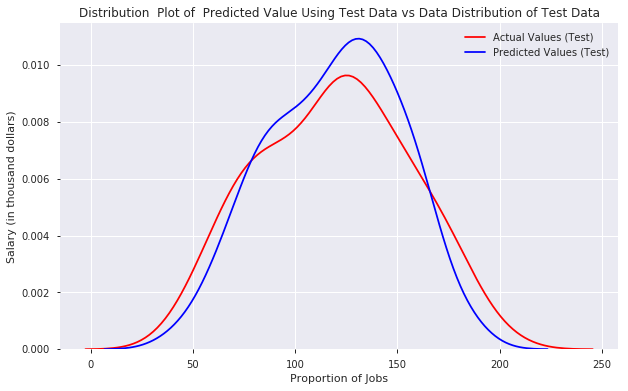

In [33]:
# View distribution of actual salaries compared to predicted salaries
Title='Linear Regressor Prediction vs Actual Values'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Linear)",Title)

#### Distribution, accuracy score, and MSE are not significantly different when comparing the training and testing data.

#### We'll try to get better MSE through 3 different models:
- Logistic Regression
- Decision Trees
- Random Forest

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The first 5 predictions are:  [111 116  98 133 133]


972.75

5-Fold Cross Validation Accuracy (test data): 0.013925100057175527 0.015525541904901295


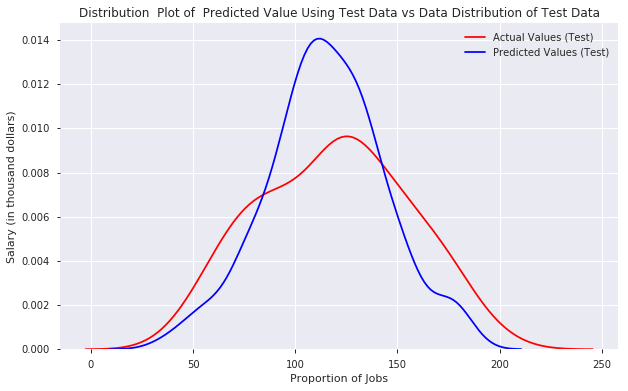

In [42]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
yhat_lg = lg_model.predict(X_test)
print('The first 5 predictions are: ', yhat_lg[0:5])
mse_lg = mean_squared_error(y_test, yhat_lg)
mse_lg
# Print accuracy score using 5-fold cross validation
scores = cross_val_score(lg_model, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (test data):", (np.mean(scores)), (np.std(scores)))
# View distribution of actual salaries compared to predicted salaries
Title='Logistic Regressor Prediction vs Actual Values'
DistributionPlot(y_test,yhat_lg,"Actual Values (Test)","Predicted Values (Log)",Title)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

The first 5 predictions are:  [103.9 115.7 151.8 112.7 150.3]


640.340375

5-Fold Cross Validation Accuracy (test data): 0.46514999741937907 0.08304699177098213


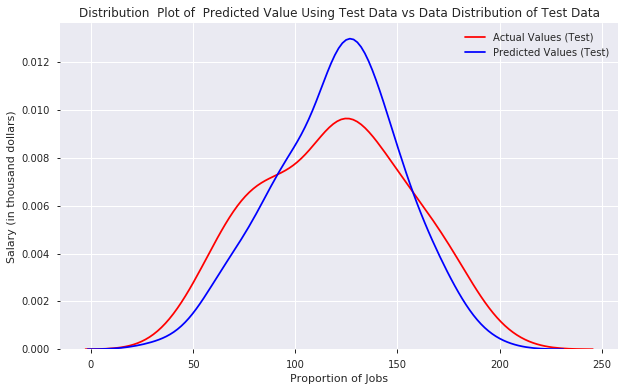

In [41]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
yhat_rf = rf_model.predict(X_test)
print('The first 5 predictions are: ', yhat_rf[0:5])
mse_rf = mean_squared_error(y_test, yhat_rf)
mse_rf
# Print accuracy score using 5-fold cross validation
scores = cross_val_score(rf_model, X_test, y_test, cv=5)
print("5-Fold Cross Validation Accuracy (Random Forest):", (np.mean(scores)), (np.std(scores)))
# View distribution of actual salaries compared to predicted salaries
Title='Random Forest Regressor Prediction vs Actual Values'
DistributionPlot(y_test,yhat_rf,"Actual Values (Test)","Predicted Values (RF)",Title)

## Part 4 - DEPLOY

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders